In [ ]:
!pip install opencv-python numpy


In [ ]:
!wget -q https://pjreddie.com/media/files/yolov3.weights
!wget -q https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
!wget -q https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names

In [ ]:
from google.colab import files
uploaded = files.upload()  # Upload your video file


Saving VIRAT_S_010204_05_000856_000890.mp4 to VIRAT_S_010204_05_000856_000890.mp4


In [ ]:
!wget -O yolov4.cfg https://raw.githubusercontent.com/AlexeyAB/darknet/master/cfg/yolov4.cfg
!wget -O yolov4.weights https://github.com/AlexeyAB/darknet/releases/download/yolov4/yolov4.weights
!wget -O coco.names https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names



--2025-03-06 03:58:07--  https://raw.githubusercontent.com/AlexeyAB/darknet/master/cfg/yolov4.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12231 (12K) [text/plain]
Saving to: ‘yolov4.cfg’

yolov4.cfg          100%[===================>]  11.94K  --.-KB/s    in 0.001s  

2025-03-06 03:58:07 (11.6 MB/s) - ‘yolov4.cfg’ saved [12231/12231]

--2025-03-06 03:58:07--  https://github.com/AlexeyAB/darknet/releases/download/yolov4/yolov4.weights
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://objects.githubusercontent.com/github-production-release-asset-2e65be/75388965/749e43d0-8605-436f-b26c-12ee01c2a265?X-Amz-Algorithm=AWS

In [ ]:
!pip uninstall -y opencv-python opencv-python-headless opencv-contrib-python
!pip install --no-cache-dir opencv-python-headless==4.5.5.62


Found existing installation: opencv-python-headless 4.5.5.62
Uninstalling opencv-python-headless-4.5.5.62:
  Successfully uninstalled opencv-python-headless-4.5.5.62
Reason for being yanked: Deprecated, use 4.7.0.64
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 99.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 2.0.4 requires opencv-python-headless>=4.9.0.80, but you have opencv-python-headless 4.5.5.62 which is incompatible.
albucore 0.0.23 requires opencv-python-headless>=4.9.0.80, but you have opencv-python-headless 4.5.5.62 which is incompatible.


Total frames in the video: 584
Enter the frame number to analyze: 47
Displaying detected objects for frame 47:


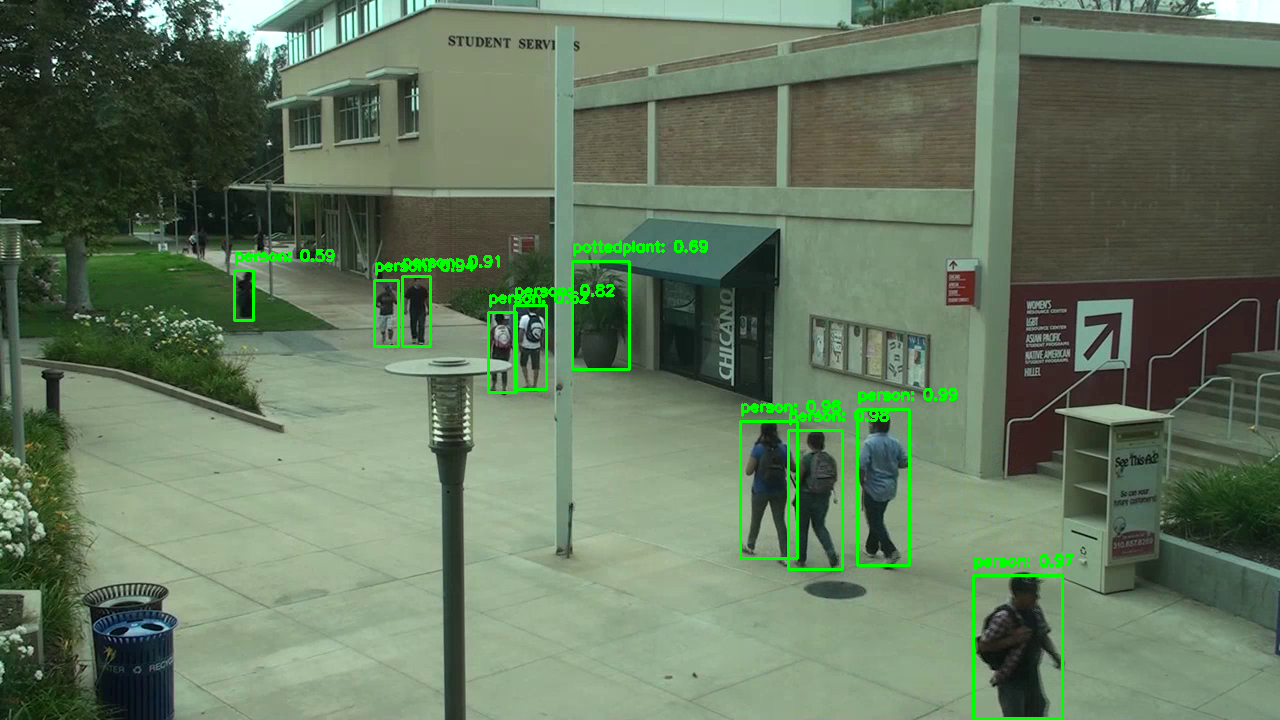

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def load_yolo():
    net = cv2.dnn.readNet("yolov4.weights", "yolov4.cfg")  # Use full model for better detection
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)  # Use CUDA if available

    with open("coco.names", "r") as f:
        classes = [line.strip() for line in f.readlines()]

    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
    return net, classes, output_layers

def get_total_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    return total_frames

def detect_objects(frame, net, output_layers):
    height, width, _ = frame.shape
    blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    return net.forward(output_layers), width, height

def draw_labels(outputs, frame, classes, width, height):
    boxes = []
    confidences = []
    class_ids = []

    for output in outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.2:  # Lower threshold to detect smaller objects
                center_x, center_y, w, h = (detection[:4] * np.array([width, height, width, height])).astype("int")
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, int(w), int(h)])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.3, 0.2)  # Adjusted NMS

    if len(indices) > 0:
        for i in indices.flatten():
            x, y, w, h = boxes[i]
            label = f"{classes[class_ids[i]]}: {confidences[i]:.2f}"
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(frame, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    return frame

def process_video(video_path, frame_number):
    net, classes, output_layers = load_yolo()
    cap = cv2.VideoCapture(video_path)

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if frame_number >= total_frames or frame_number < 0:
        print(f"Invalid frame number! Please enter a number between 0 and {total_frames - 1}.")
        cap.release()
        return

    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()

    if not ret:
        print("Error: Could not retrieve the specified frame!")
        return

    outputs, width, height = detect_objects(frame, net, output_layers)
    processed_frame = draw_labels(outputs, frame, classes, width, height)

    print(f"Displaying detected objects for frame {frame_number}:")
    cv2_imshow(processed_frame)

if __name__ == "__main__":
    video_path = "VIRAT_S_010204_05_000856_000890.mp4"  # Replace with actual video file path
    total_frames = get_total_frames(video_path)
    print(f"Total frames in the video: {total_frames}")
    frame_number = int(input("Enter the frame number to analyze: "))
    process_video(video_path, frame_number)
